# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

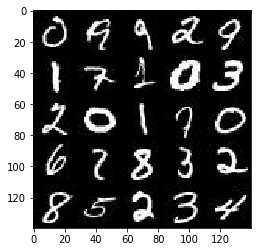

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

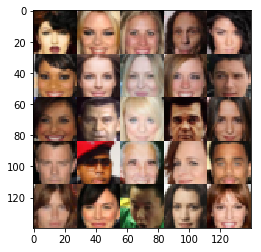

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [6]:
mnist_images.shape

(25, 28, 28, 3)

In [7]:
mnist_images.shape[-3:]

(28, 28, 3)

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [8]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [9]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    lr = tf.placeholder(tf.float32, name='lr')
    
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    #input dim will be that of generator output dim, i.e, 28x28xout_chan_dim(3)
    with tf.variable_scope('discriminator', reuse=reuse):
        #conv layer1
        x1 = tf.layers.conv2d(images,64, (5,5), strides=(2,2), padding='same')
        #bn1 = tf.layers.batch_normalization(x1, training=True)
        #commenting out the above batch normalization mistake (and below line), since Ian goodwell's lecture says not to do.
        #relu1 = tf.maximum(alpha * bn1, bn1)
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        #conv layer2
        x2 = tf.layers.conv2d(relu1, 128, (5,5), strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
         #conv layer3
        x3 = tf.layers.conv2d(relu2, 256, (5,5), strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        #flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        #Input
        x1 = tf.layers.dense(z, 7*7*64)
        # reshape it 
        reshaped1 = tf.reshape(x1, (-1,7,7,64))
        bn1 = tf.layers.batch_normalization(reshaped1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 7x7x64 is the output (chngd frm 128)
        
        x2 = tf.layers.conv2d_transpose(relu1, 32, 5, strides=(2,2), padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x32
        
        x3 = tf.layers.conv2d_transpose(relu2, 16, 5, strides=(2,2), padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 28x28x16
        
        #logits
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=(1,1), padding='same')
        # should be 28x28x3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_out = generator(z=input_z, out_channel_dim=out_channel_dim, is_train=True)
    discriminator_out_real, discriminator_logits_real = discriminator(images=input_real, reuse=False)
    discriminator_out_z, discriminator_logits_z = discriminator(images = generator_out, reuse=True)
    
    discriminator_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_real, labels=tf.ones_like(discriminator_out_real)*0.9))
    
    discriminator_loss_z = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels = tf.zeros_like(discriminator_out_z)))
    
    generator_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=discriminator_logits_z, labels=tf.ones_like(discriminator_out_z)))
    
    discriminator_loss_total = discriminator_loss_real + discriminator_loss_z
    
    return discriminator_loss_total, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_variables = tf.trainable_variables()
    discriminator_variables = [var for var in t_variables if var.name.startswith('discriminator')]
    generator_variables = [var for var in t_variables if var.name.startswith('generator')]
    
    #optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=discriminator_variables)
        generator_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_variables)
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    losses = []
    steps = 0
    print_every=10
    show_every=100
    
    image_width, image_height, image_channel_depth  = data_shape[-3:]
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channel_depth, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z,out_channel_dim=image_channel_depth)
    disc_optimizer, gen_optimizer = model_opt(disc_loss, gen_loss, lr, beta1=beta1)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                
                #random noise sample
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                #running optimizers
                _ = sess.run(disc_optimizer, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                for i in range(5):
                    _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                #print stats
                if steps % print_every ==0:
                    disc_loss_train = disc_loss.eval({input_real: batch_images, input_z: batch_z})
                    gen_loss_train = gen_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(disc_loss_train),
                          "Generator Loss: {:.4f}".format(gen_loss_train))
                    
                    losses.append((disc_loss_train, gen_loss_train))
                    
                #show images
                if steps% show_every ==0:
                    show_generator_output(sess, 16, input_z, image_channel_depth, data_image_mode)
        
        #each epoch
        saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.9675... Generator Loss: 0.0497
Epoch 1/2... Discriminator Loss: 2.7820... Generator Loss: 0.1163
Epoch 1/2... Discriminator Loss: 2.0737... Generator Loss: 0.2225
Epoch 1/2... Discriminator Loss: 1.8892... Generator Loss: 0.2719
Epoch 1/2... Discriminator Loss: 1.7084... Generator Loss: 0.3318
Epoch 1/2... Discriminator Loss: 1.6214... Generator Loss: 0.3680
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.3931
Epoch 1/2... Discriminator Loss: 1.4443... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.5000


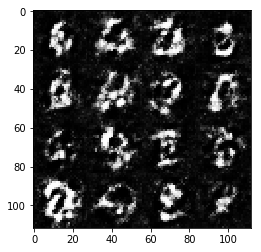

Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.5274
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.5151
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.4535
Epoch 1/2... Discriminator Loss: 1.8389... Generator Loss: 0.2660
Epoch 1/2... Discriminator Loss: 1.7522... Generator Loss: 0.3153
Epoch 1/2... Discriminator Loss: 1.5654... Generator Loss: 0.3861
Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 0.4679
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.3652... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.7250


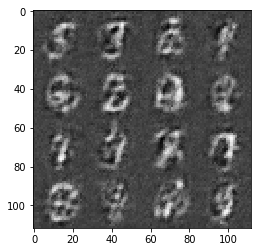

Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 1.2084... Generator Loss: 0.6133
Epoch 1/2... Discriminator Loss: 1.3671... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.5273
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.4803
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.2784... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.4837


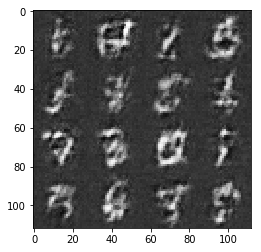

Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 1.6610
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 1.3090
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 1.4726
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 2.2267... Generator Loss: 1.6238
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.1266
Epoch 1/2... Discriminator Loss: 0.8870... Generator Loss: 1.3450
Epoch 1/2... Discriminator Loss: 0.8554... Generator Loss: 1.7174
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.8005


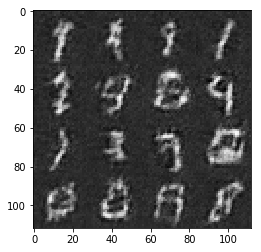

Epoch 1/2... Discriminator Loss: 0.9423... Generator Loss: 1.0183
Epoch 1/2... Discriminator Loss: 1.1442... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 2.2604
Epoch 1/2... Discriminator Loss: 2.2812... Generator Loss: 1.7725
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.6651
Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.7440
Epoch 2/2... Discriminator Loss: 0.6666... Generator Loss: 2.0817
Epoch 2/2... Discriminator Loss: 0.7278... Generator Loss: 1.4889
Epoch 2/2... Discriminator Loss: 2.2949... Generator Loss: 0.4562


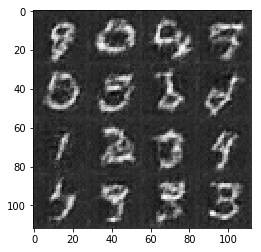

Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.0272
Epoch 2/2... Discriminator Loss: 0.6862... Generator Loss: 1.5780
Epoch 2/2... Discriminator Loss: 0.6349... Generator Loss: 1.6108
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.7948
Epoch 2/2... Discriminator Loss: 1.6285... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 3.2569... Generator Loss: 3.3192
Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.5467
Epoch 2/2... Discriminator Loss: 1.7234... Generator Loss: 0.3092
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 0.5968


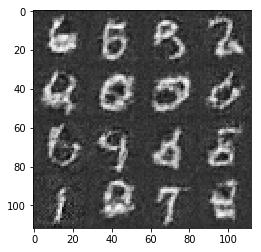

Epoch 2/2... Discriminator Loss: 0.5587... Generator Loss: 2.2666
Epoch 2/2... Discriminator Loss: 0.8996... Generator Loss: 1.1173
Epoch 2/2... Discriminator Loss: 0.7690... Generator Loss: 1.7322
Epoch 2/2... Discriminator Loss: 1.7325... Generator Loss: 0.3316
Epoch 2/2... Discriminator Loss: 1.6153... Generator Loss: 0.3612
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.4651
Epoch 2/2... Discriminator Loss: 1.6851... Generator Loss: 0.3180
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 1.1331
Epoch 2/2... Discriminator Loss: 1.1205... Generator Loss: 1.0572
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 2.1709


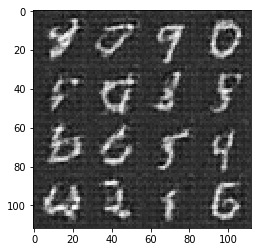

Epoch 2/2... Discriminator Loss: 1.0009... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 1.8566... Generator Loss: 0.2762
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.6432
Epoch 2/2... Discriminator Loss: 0.5862... Generator Loss: 1.6525
Epoch 2/2... Discriminator Loss: 2.9867... Generator Loss: 0.1080
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.5468
Epoch 2/2... Discriminator Loss: 1.4478... Generator Loss: 0.4295
Epoch 2/2... Discriminator Loss: 0.7551... Generator Loss: 1.1680
Epoch 2/2... Discriminator Loss: 0.6209... Generator Loss: 1.5147
Epoch 2/2... Discriminator Loss: 1.5265... Generator Loss: 0.6057


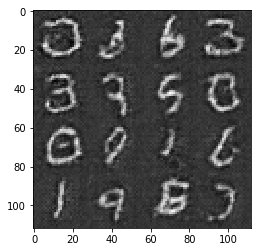

Epoch 2/2... Discriminator Loss: 1.2088... Generator Loss: 1.0868
Epoch 2/2... Discriminator Loss: 0.5632... Generator Loss: 2.4712
Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 0.3858
Epoch 2/2... Discriminator Loss: 0.5442... Generator Loss: 1.7810
Epoch 2/2... Discriminator Loss: 1.9528... Generator Loss: 0.2423
Epoch 2/2... Discriminator Loss: 1.3832... Generator Loss: 1.1482
Epoch 2/2... Discriminator Loss: 1.4044... Generator Loss: 0.4657
Epoch 2/2... Discriminator Loss: 0.5581... Generator Loss: 2.4486
Epoch 2/2... Discriminator Loss: 0.6676... Generator Loss: 1.3358
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 1.0990


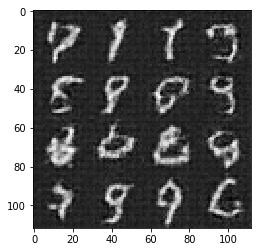

Epoch 2/2... Discriminator Loss: 0.8933... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 1.9065... Generator Loss: 0.2571
Epoch 2/2... Discriminator Loss: 1.7285... Generator Loss: 2.3271


In [29]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.6913
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 1.1871
Epoch 1/1... Discriminator Loss: 1.7309... Generator Loss: 2.4237
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 1.9802
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 2.2194
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 2.7154
Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 2.3941
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 2.4929
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 1.7024
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 1.7052


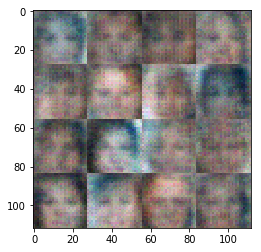

Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 1.2474
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 1.1118
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.3785
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 1.2537
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 1.7246
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 1.0199
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 1.2391
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.8489


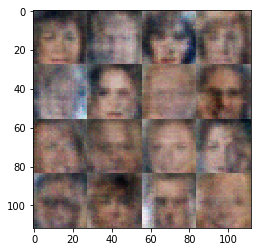

Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 1.7568
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 1.1320
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.8370
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 1.2253
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 1.1925
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.9025


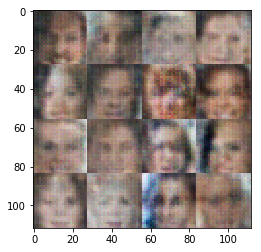

Epoch 1/1... Discriminator Loss: 1.7459... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.5514
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 1.4969
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.9146
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.5107... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.4092


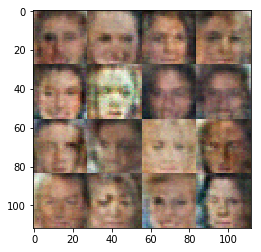

Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 2.0425... Generator Loss: 0.2135
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 1.2934
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 1.6173
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 2.2622
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.8039... Generator Loss: 0.2922
Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 0.3768


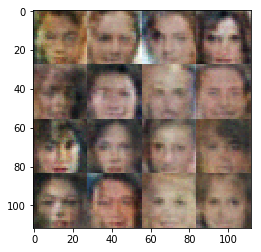

Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.4292
Epoch 1/1... Discriminator Loss: 1.8589... Generator Loss: 0.2651
Epoch 1/1... Discriminator Loss: 1.5846... Generator Loss: 0.3845
Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 3.1682
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.6511
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 2.1067
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 2.1111... Generator Loss: 0.2067
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.8743


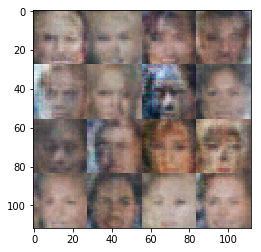

Epoch 1/1... Discriminator Loss: 0.8562... Generator Loss: 2.4611
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.7508
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.4182
Epoch 1/1... Discriminator Loss: 1.7906... Generator Loss: 0.2991
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.4636
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 0.7698


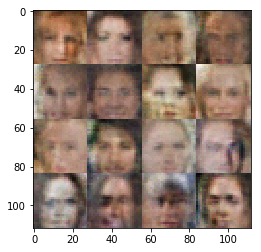

Epoch 1/1... Discriminator Loss: 1.8505... Generator Loss: 0.2732
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.4226
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.7128
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 0.3530
Epoch 1/1... Discriminator Loss: 1.6637... Generator Loss: 0.3785
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.8538... Generator Loss: 0.2740
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8165


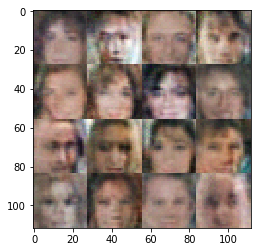

Epoch 1/1... Discriminator Loss: 1.6686... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.4378
Epoch 1/1... Discriminator Loss: 1.6223... Generator Loss: 0.3864
Epoch 1/1... Discriminator Loss: 1.9650... Generator Loss: 0.2422
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.3694
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 1.6904... Generator Loss: 0.3329


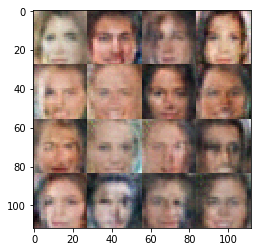

Epoch 1/1... Discriminator Loss: 1.7334... Generator Loss: 0.3265
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.6984... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.8650... Generator Loss: 1.5147
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.6115
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 1.8822
Epoch 1/1... Discriminator Loss: 1.6586... Generator Loss: 1.7450


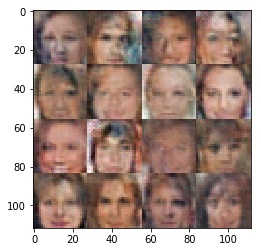

Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 1.3576
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 1.6746
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.7661... Generator Loss: 0.3088
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 1.6230... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 1.8741... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.5001
Epoch 1/1... Discriminator Loss: 1.6900... Generator Loss: 0.3282


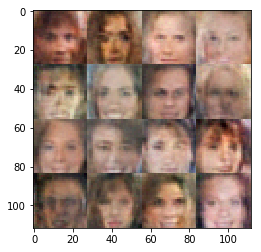

Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 0.2909
Epoch 1/1... Discriminator Loss: 1.7136... Generator Loss: 0.3307
Epoch 1/1... Discriminator Loss: 1.9824... Generator Loss: 0.2371
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.7351
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.3806
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 1.5628
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.7893


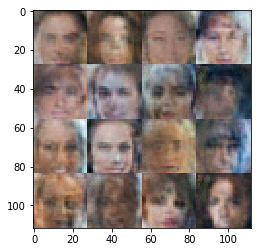

Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 2.1937
Epoch 1/1... Discriminator Loss: 1.7694... Generator Loss: 1.5859
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.8596... Generator Loss: 0.2699
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.3709
Epoch 1/1... Discriminator Loss: 1.5904... Generator Loss: 0.3726


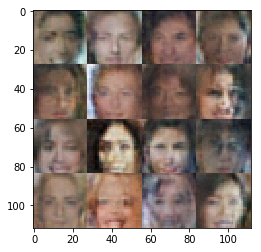

Epoch 1/1... Discriminator Loss: 1.8252... Generator Loss: 0.2767
Epoch 1/1... Discriminator Loss: 1.7182... Generator Loss: 0.3136
Epoch 1/1... Discriminator Loss: 1.8387... Generator Loss: 0.2689
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.3673
Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 0.3230
Epoch 1/1... Discriminator Loss: 1.8111... Generator Loss: 0.2902
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.2269... Generator Loss: 1.5369
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 1.9238


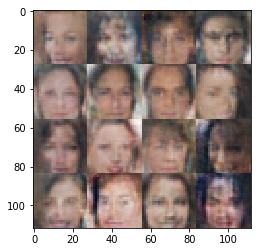

Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.4181
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.3819
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.6991... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.1713... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.7930... Generator Loss: 1.3899
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.2792
Epoch 1/1... Discriminator Loss: 0.9796... Generator Loss: 1.1650


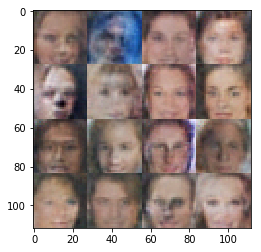

Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.5271... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 1.7270
Epoch 1/1... Discriminator Loss: 1.9083... Generator Loss: 1.3304
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7256


In [30]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.